In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
import recordlinkage
from scipy.optimize import linear_sum_assignment

df_h = pd.read_csv('../data/hollingsworth/wrangled/peers.csv', low_memory=False, index_col=0)
df_l = pd.read_csv('../data/thepeerage/wrangled/wrangled_peerage.csv', low_memory=False)

In [2]:
print(len(df_h))

28423


In [3]:
print(len(df_l))

757192


In [4]:
#mask = (
#    df_l['Extracted Parental Peerage_l']
#      .str.contains(r'\bbaron\b', regex=True, na=False)
#    | df_l['Extracted Parental Peerage_l']
#    .str.contains(r'\bearl\b', regex=True, na=False)
#    | df_l['Extracted Parental Peerage_l']
#    .str.contains(r'\bviscount\b', regex=True, na=False)
#    | df_l['Extracted Parental Peerage_l']
#    .str.contains(r'\bmarquess\b', regex=True, na=False)
#    | df_l['Extracted Parental Peerage_l']
#    .str.contains(r'\bjacobite\b', regex=True, na=False)
#    | df_l['Extracted Parental Peerage_l']
#    .str.contains(r'\bduke\b', regex=True, na=False)
#    | df_l['Extracted Parental Peerage_l']
#    .str.contains(r'\bbaron_by_writ\b', regex=True, na=False)
#    | df_l['Extracted Parental Peerage']
#    .str.contains(r'\blife_peer\b', regex=True, na=False)       # has "baron" as a full token
#  &
#(df_l['Extracted Parental Peerage_l']!='baronet')     # but not "baronet"
#)
#df_l1 = df_l.loc[mask]
#df_l1 = df_l1[((df_l1['born_year_l']>=1527) & (df_l1['born_year_l']<=1945))]
#
#
#
#df_h1 = df_h[df_h['Extracted Parental Peerage_h'].notnull()]
#df_h1 = df_h1[df_h1['born_year_h'].notnull()]
#df_h1 = df_h[(df_h['born_accuracy_h']=='y') |
#             (df_h['born_accuracy_h']=='Y') |
#             (df_h['born_accuracy_h']=='x') |
#             (df_h['born_accuracy_h']=='1') |
#             (df_h['born_accuracy_h']=='2') |
#             (df_h['born_accuracy_h']=='3')]

In [5]:
import pandas as pd
import numpy as np
import recordlinkage
from recordlinkage.index import SortedNeighbourhood
from scipy.optimize import linear_sum_assignment
import time  # for profiling

# Function to print time taken
def print_time_elapsed(start_time, label):
    end_time = time.time()
    print(f"{label} - Time elapsed: {end_time - start_time:.4f} seconds")
    return end_time

# --- 0) Prep & rename ---
start_time = time.time()

df_h2 = (
    df_h
    .reset_index(drop=True)
    .rename(columns={
        'First Forename_h': 'forename',
        'Last Surname_h':    'surname',
        'born_year_h':       'born_year',
        'died_year_h':       'died_year'
    })
    .reset_index()
    .rename(columns={'index': 'h_index'})
)

df_l2 = (
    df_l
    .reset_index(drop=True)
    .rename(columns={
        'First Forename_l': 'forename',
        'Last Surname_l':    'surname',
        'born_year_l':       'born_year',
        'died_year_l':       'died_year'
    })
    .reset_index()
    .rename(columns={'index': 'l_index'})
)

start_time = print_time_elapsed(start_time, "0) Prep & rename")

# --- 1) Filter out missing years & bin into decades ---
df_h2['year_bin']       = (df_h2['born_year'] // 10).astype('Int64')
df_l2['year_bin']       = (df_l2['born_year'] // 10).astype('Int64')
df_h2['died_year_bin']  = (df_h2['died_year'] // 10).astype('Int64')
df_l2['died_year_bin']  = (df_l2['died_year'] // 10).astype('Int64')

start_time = print_time_elapsed(start_time, "1) Filter & bin into decades")

# --- 2) Build candidate_index via SortedNeighbourhood on forename ---
df_h2i = df_h2.set_index('h_index')
df_l2i = df_l2.set_index('l_index')

indexer = SortedNeighbourhood(left_on='forename', window=11)
candidate_index = indexer.index(df_h2i, df_l2i)

start_time = print_time_elapsed(start_time, "2) Build candidate_index")

# --- 3) Compute string & year-difference scores ---
compare = recordlinkage.Compare()
compare.string('forename', 'forename', method='jarowinkler', threshold=None, label='forename_score')
compare.string('surname',  'surname',  method='jarowinkler', threshold=None, label='surname_score')

features = compare.compute(candidate_index, df_h2i, df_l2i)

h_year = df_h2i.loc[features.index.get_level_values(0), 'born_year'].values
l_year = df_l2i.loc[features.index.get_level_values(1), 'born_year'].values
features['year_score'] = np.where(
    pd.isna(h_year) | pd.isna(l_year),
    0,
    (1 - np.abs(h_year - l_year) / 10).clip(0, 1)
)

h_died = df_h2i.loc[features.index.get_level_values(0), 'died_year'].values
l_died = df_l2i.loc[features.index.get_level_values(1), 'died_year'].values
features['died_year_score'] = np.where(
    pd.isna(h_died) | pd.isna(l_died),
    np.nan,
    (1 - np.abs(h_died - l_died) / 10).clip(0, 1)
)

start_time = print_time_elapsed(start_time, "3) Compute scores")

# --- 4) Tighten thresholds ---
features = features[
    (features['forename_score'] > 0.75) &
    (features['surname_score']  > 0.75) &
    (features['year_score']     > 0.650)
]

start_time = print_time_elapsed(start_time, "4) Tighten thresholds")

# --- 5) Composite weight + Hungarian assignment ---
α, β, γ = 0.2, 0.4, 0.4
features['weight'] = (
      α * features['forename_score']
    + β * features['surname_score']
    + γ * features['year_score']
)

h_ids = features.index.get_level_values(0).unique()
l_ids = features.index.get_level_values(1).unique()
h_map = {h: i for i, h in enumerate(h_ids)}
l_map = {l: j for j, l in enumerate(l_ids)}

C = np.zeros((len(h_ids), len(l_ids)), float)
for (h, l), w in features['weight'].items():
    C[h_map[h], l_map[l]] = -w

row_ind, col_ind = linear_sum_assignment(C)
matches = [
    (h_ids[i], l_ids[j], -C[i, j])
    for i, j in zip(row_ind, col_ind)
    if -C[i, j] > 0
]

start_time = print_time_elapsed(start_time, "5) Composite weight + Hungarian assignment")

# --- 6) Assemble matched results ---
matches_df = pd.DataFrame(matches, columns=['h_index','l_index','match_weight'])
matches_df = matches_df.join(
    features[['forename_score','surname_score','year_score','died_year_score']],
    on=['h_index','l_index']
)

final_df = (
    matches_df
    .merge(df_h2, on='h_index', how='left')
    .merge(df_l2, on='l_index', how='left', suffixes=('_h','_l'))
    .reset_index(drop=True)
)

start_time = print_time_elapsed(start_time, "6) Assemble results")

# Print matched pairs
print(final_df)

# --- 7) Append unmatched records with proper suffix renaming ---
matched_h = set(matches_df['h_index'])
matched_l = set(matches_df['l_index'])

# Unmatched from the h-dataset
unmatched_h = df_h2[~df_h2['h_index'].isin(matched_h)].copy()
unmatched_h = unmatched_h.rename(columns={
    'forename':      'forename_h',
    'surname':       'surname_h',
    'born_year':     'born_year_h',
    'died_year':     'died_year_h',
    'year_bin':      'year_bin_h',
    'died_year_bin': 'died_year_bin_h'
})
unmatched_h['l_index']        = np.nan
unmatched_h['match_weight']   = np.nan
unmatched_h['forename_score'] = np.nan
unmatched_h['surname_score']  = np.nan
unmatched_h['year_score']     = np.nan
# align columns
unmatched_h = unmatched_h.reindex(columns=final_df.columns)

# Unmatched from the l-dataset
unmatched_l = df_l2[~df_l2['l_index'].isin(matched_l)].copy()
unmatched_l = unmatched_l.rename(columns={
    'forename':      'forename_l',
    'surname':       'surname_l',
    'born_year':     'born_year_l',
    'died_year':     'died_year_l',
    'year_bin':      'year_bin_l',
    'died_year_bin': 'died_year_bin_l'
})
unmatched_l['h_index']        = np.nan
unmatched_l['match_weight']   = np.nan
unmatched_l['forename_score'] = np.nan
unmatched_l['surname_score']  = np.nan
unmatched_l['year_score']     = np.nan

0) Prep & rename - Time elapsed: 0.1607 seconds
1) Filter & bin into decades - Time elapsed: 0.1101 seconds
2) Build candidate_index - Time elapsed: 63.4528 seconds
3) Compute scores - Time elapsed: 493.2873 seconds
4) Tighten thresholds - Time elapsed: 0.9372 seconds
5) Composite weight + Hungarian assignment - Time elapsed: 0.9606 seconds
6) Assemble results - Time elapsed: 0.1377 seconds
       h_index  l_index  match_weight  forename_score  surname_score  \
0           92   534840      0.904000        1.000000       0.760000   
1         1529   101185      0.810667        0.933333       0.760000   
2         2172   175124      1.000000        1.000000       1.000000   
3         4666   643265      0.932778        0.952778       0.855556   
4         5534   475231      0.830556        0.952778       0.800000   
...        ...      ...           ...             ...            ...   
13305    24442   364240      0.818571        0.942857       0.775000   
13306    25821   396911      0

In [6]:
final_df_clean = final_df.dropna(axis=1, how='all')
unmatched_h_clean = unmatched_h.dropna(axis=1, how='all')
unmatched_l_clean = unmatched_l.dropna(axis=1, how='all')

# Concatenate cleaned DataFrames
full_df = pd.concat(
    [final_df_clean, unmatched_h_clean, unmatched_l_clean],
    ignore_index=True,
    sort=False
)

<Axes: xlabel='born_year_h', ylabel='born_year_l'>

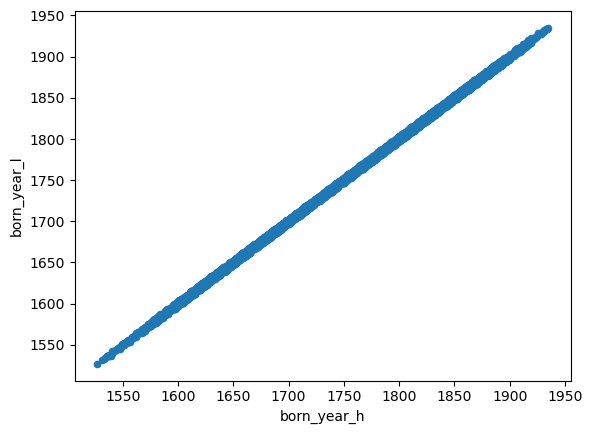

In [7]:
full_df[['born_year_l', 'born_year_h']].plot(kind='scatter', x='born_year_h', y= 'born_year_l')

In [8]:
import os
from datetime import datetime

# Get current date and time
now = datetime.now()

# Correct format: minute, hour, day, month, year
formatted_date = now.strftime("%H%M_%d%m%Y")

# Define the directory path
directory_path = os.path.join('..', 'data', 'matched', formatted_date)

# Check if the directory exists, and create it along with any necessary parent directories
if not os.path.exists(directory_path):
    os.makedirs(directory_path)  # This will create all necessary parent directories

# Save your DataFrame to CSV in the newly created directory
full_df.to_csv(os.path.join(directory_path, 'matched_hollingsworth_and_lundy.csv'))
